#  Housekeeping Unit Test

This notebook contains a Unit Test for the housekeeping information from the Observatory Simulator.

### Starting the Observatory Simulator

First start the FPE, you might need to preload the `FPE_Wrapper` if you have not already (TODO: make this smart so operators don't have to keep track of this)

In [1]:
from tessfpe.dhu.fpe import FPE
fpe1 = FPE(1, preload=True, debug=False)
#fpe1 = FPE(1)

As a quick diagnostic, we start and stop capture frames.

In [2]:
fpe1.cmd_start_frames()

'Starting frames...'

In [3]:
fpe1.cmd_stop_frames()

'Frames Stopped...'

Now we collect the measurements; this will make 10 sets of samples for heater currents that are between 0 and 150 mA, spaced out by 10 mA.

In [4]:
measurements = []
for i in range(0,1500,10):
    a = i % 150
    b = (i + 70) % 150
    c = (150 - i) % 150
    fpe1.ops.heater_1_current = a
    fpe1.ops.heater_2_current = b
    fpe1.ops.heater_3_current = c
    fpe1.ops.send()
    measurements.append({"set": {"heater_1_current": a, 
                                 "heater_2_current": b,
                                 "heater_3_current": c},
                         "measured": {"heater_1_current": fpe1.house_keeping["analogue"]["heater_1_current"],
                                      "heater_2_current": fpe1.house_keeping["analogue"]["heater_2_current"],
                                      "heater_3_current": fpe1.house_keeping["analogue"]["heater_3_current"]}})
measurements

[{'measured': {'heater_1_current': 2.057830810546875,
   'heater_2_current': 69.249755859375,
   'heater_3_current': 1.174713134765625},
  'set': {'heater_1_current': 0,
   'heater_2_current': 70,
   'heater_3_current': 0}},
 {'measured': {'heater_1_current': 11.81378173828125,
   'heater_2_current': 79.18899536132812,
   'heater_3_current': 137.09152221679688},
  'set': {'heater_1_current': 10,
   'heater_2_current': 80,
   'heater_3_current': 140}},
 {'measured': {'heater_1_current': 21.553070068359375,
   'heater_2_current': 89.03659057617188,
   'heater_3_current': 127.3355712890625},
  'set': {'heater_1_current': 20,
   'heater_2_current': 90,
   'heater_3_current': 130}},
 {'measured': {'heater_1_current': 31.334014892578125,
   'heater_2_current': 98.73422241210938,
   'heater_3_current': 117.5379638671875},
  'set': {'heater_1_current': 30,
   'heater_2_current': 100,
   'heater_3_current': 120}},
 {'measured': {'heater_1_current': 41.0233154296875,
   'heater_2_current': 108.6

## Plots

Let's first plot the `set` value on the $x$ axis versus the `measured` value on the $y$ axis to test how well calibrated the sensors are:

In [45]:
x1 = [i["set"]["heater_1_current"] for i in measurements]
y1 = [j["measured"]["heater_1_current"] for j in measurements]
x2 = [i["set"]["heater_2_current"] for i in measurements]
y2 = [j["measured"]["heater_2_current"] for j in measurements]
x3 = [i["set"]["heater_3_current"] for i in measurements]
y3 = [j["measured"]["heater_3_current"] for j in measurements]

In [46]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [47]:
import numpy as np
import matplotlib.pyplot as plt

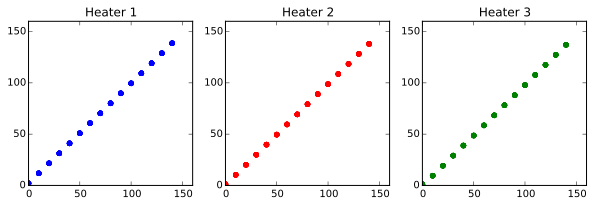

In [48]:
f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(331, aspect='equal')
ax1.set_title('Heater 1')
ax1.scatter(x1,y1,color='blue')
ax1.locator_params(nbins=4)
ax1.set_xlim([0,160])
ax1.set_ylim([0,160])

ax2 = f.add_subplot(332, aspect='equal')
ax2.set_title('Heater 2')
ax2.scatter(x2,y2,color='red')
ax2.locator_params(nbins=4)
ax2.set_xlim([0,160])
ax2.set_ylim([0,160])

ax3 = f.add_subplot(333, aspect='equal')
ax3.set_title('Heater 3')
ax3.scatter(x3,y3,color='green')
ax3.locator_params(nbins=4)
ax3.set_xlim([0,160])
ax3.set_ylim([0,160])
plt.show()

As we can see, the measured heater values from the housekeeping are roughly the same as the values set values, up to an *affine transformation*. To see this, it is helpful to compute `measured - set` to see the errors:

In [49]:
err1 = map(lambda y,x: y-x, y1, x1)
err2 = map(lambda y,x: y-x, y2, x2)
err3 = map(lambda y,x: y-x, y3, x3)

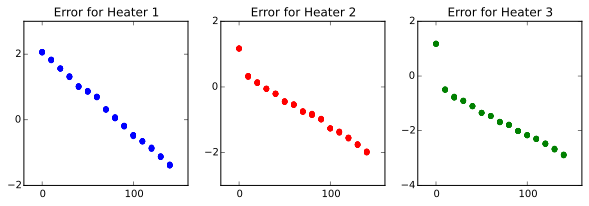

In [57]:
f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(331)
ax1.set_title('Error for Heater 1')
ax1.locator_params(nbins=4)
ax1.set_xlim([-20,160])
ax1.scatter(x1,err1,color='blue')

ax2 = f.add_subplot(332)
ax2.set_title('Error for Heater 2')
ax2.locator_params(nbins=4)
ax2.set_xlim([-20,160])
ax2.scatter(x2,err2,color='red')

ax3 = f.add_subplot(333)
ax3.set_title('Error for Heater 3')
ax3.locator_params(nbins=4)
ax3.set_xlim([-20,160])
ax3.scatter(x3,err3,color='green')
plt.show()

From the above we can infer that in order to correct for the error we need to disregard the measured values when the heaters are set to 0 mA, since they are apparently outliars.

## Calibration

We next turn to calibrating the heaters.

The above analysis only really looks at 3 heaters; we can see that the error measurements have an outliar at 0 mA, but it is of interest to reproduce this analysis for more than N=3 components.  This should be as simple as rerunning this notebook, however.

For the time being we are proceeding with calibration by performing a simple *linear regression*, computing $slope$ and $intercept$ in:
$$ \texttt{set_value} = slope \cdot \texttt{observed_value} + intercept $$

Making sure to *avoid* $\texttt{set_value} = 0$ where outliars have been observed

In [59]:
def get_set_observed(heater_current, measurements):
    return ([i["set"][heater_current] for i in measurements 
             if i["set"][heater_current] != 0],
            [j["measured"][heater_current] for j in measurements 
             if j["set"][heater_current] != 0])

def calibrate(heater_current, measurements):
    from scipy import stats
    y,x = get_set_observed(heater_current, measurements)
    return stats.linregress(x,y)

def error_correction_function(heater_current, measurements):
    slope, intercept, r_value, p_value, std_err = \
       calibrate(heater_current, measurements)
    return (lambda x: slope * x + intercept)

Now that we can compute the error correction function, we turn to looking at the error again, after calibration.

In [60]:
err_corr1 = error_correction_function("heater_1_current", measurements)
err_corr2 = error_correction_function("heater_2_current", measurements)
err_corr3 = error_correction_function("heater_3_current", measurements)

x1 = [i["set"]["heater_1_current"] for i in measurements]
y1 = [err_corr1(j["measured"]["heater_1_current"]) for j in measurements]
x2 = [i["set"]["heater_2_current"] for i in measurements]
y2 = [err_corr2(j["measured"]["heater_2_current"]) for j in measurements]
x3 = [i["set"]["heater_3_current"] for i in measurements]
y3 = [err_corr3(j["measured"]["heater_3_current"]) for j in measurements]

err1 = map(lambda y,x: y-x, y1, x1)
err2 = map(lambda y,x: y-x, y2, x2)
err3 = map(lambda y,x: y-x, y3, x3)

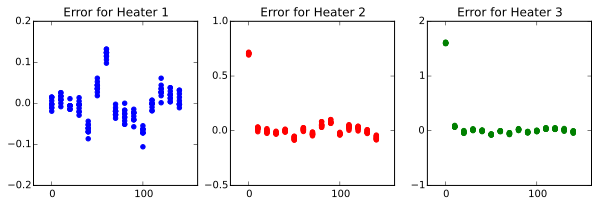

In [61]:
f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(331)
ax1.set_title('Error for Heater 1')
ax1.locator_params(nbins=4)
ax1.set_xlim([-20,160])
ax1.scatter(x1,err1,color='blue')

ax2 = f.add_subplot(332)
ax2.set_title('Error for Heater 2')
ax2.locator_params(nbins=4)
ax2.set_xlim([-20,160])
ax2.scatter(x2,err2,color='red')

ax3 = f.add_subplot(333)
ax3.set_title('Error for Heater 3')
ax3.locator_params(nbins=4)
ax3.set_xlim([-20,160])
ax3.scatter(x3,err3,color='green')
plt.show()

As we can see, after calibration we have an order of magniture less error.

The next steps we suggest are:

  - Incorporate metered current into calibration
  - Incorporate $slope$ and $intercept$ into heater control system